# Sorsogon: Simple Simulation Example

### Import libraries

In [1]:
from smum.microsim.run import run_calibrated_model
from smum.microsim.table import TableModel

/home/esteban/workspace/python/urbanmetabolism_repo/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Global variables

In [2]:
census_file = 'data/benchmarks_year_bias.csv'

## 1. Define Table model

In [3]:
tm = TableModel(census_file = census_file)

### Income model

In [4]:
tm.from_excel("data/tableModel_Income.xlsx", "Income")
formula_income = "i_Intercept +\
    c_i_Sex        * i_Sex + \
    c_i_Urbanity   * i_Urbanity + \
    c_i_Size       * i_Size + \
    c_i_Age        * i_Age + \
    c_i_Education  * i_Education"
tm.add_formula(formula_income, 'Income')

### Food model

In [5]:
tm.from_excel("data/tableModel_Food.xlsx", "Food")
formula_income = "f_Intercept +\
    c_f_Sex        * i_Sex + \
    c_f_Urbanity   * i_Urbanity + \
    c_f_Size       * i_Size + \
    c_f_Age        * i_Age + \
    c_f_Education  * i_Education +\
    c_f_Income     * Income"
tm.add_formula(formula_income, 'Food')

### Make table model

In [6]:
table_model = tm.make_model()

## 2. Define model variables

In [7]:
labels = ['age_0_18', 'age_19_25', 'age_26_35',
          'age_36_45', 'age_46_55', 'age_56_65',
          'age_66_75', 'age_76_85', 'age_86_100']
cut = [0, 19, 26, 36, 46, 56, 66, 76, 86, 101]
to_cat = {'i_Age':[cut, labels]}
drop_col_survey = ['f_Income', 'f_Education', '']

## 3. Run Simulation

In [8]:
fw = run_calibrated_model(
    table_model,
    census_file = census_file,
    year = 2016,
    name = "Sorsogon_food",
    drop_col_survey = drop_col_survey,
    to_cat = to_cat,
    verbose = False
)

loop: 1/3; calibrating: Income; sufix = loop_1


100%|██████████| 1510/1510 [00:07<00:00, 211.26it/s]


loop: 2/3; calibrating: Food; sufix = loop_2


100%|██████████| 1510/1510 [00:10<00:00, 138.45it/s]


loop: 3/3; final loop, for variables: Income, Food; sufix = loop_3


100%|██████████| 1510/1510 [00:12<00:00, 123.58it/s]


Calibration Error:
	-4.3262E-06  Income
	-1.3165E+01  Food
Projecting sample survey for 21 steps via reweight


## 4. Validate Simulation

In [19]:
from smum.microsim.util_plot import plot_error

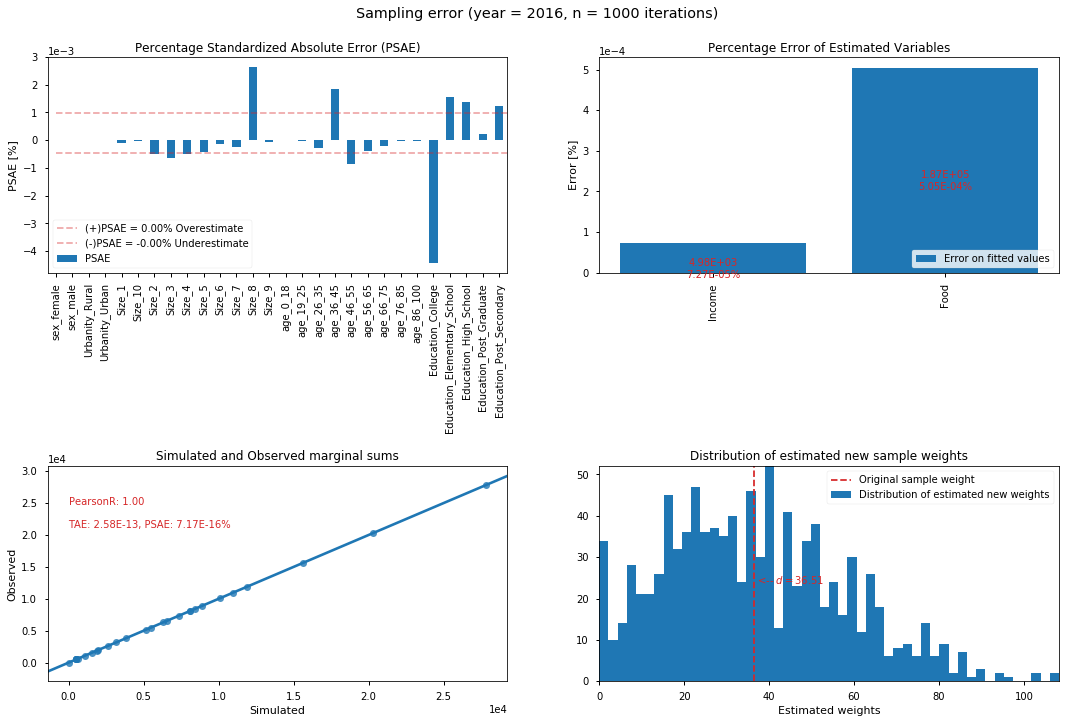

In [20]:
REC = plot_error(
    'data/survey_Sorsogon_food.csv',
    'data/benchmarks_year_bias.csv',
    '1000 iterations',
    year = 2016,
    fit_cols = ['Income', 'Food'],
)

In [13]:
import pandas as pd
survey = pd.read_csv('data/survey_Sorsogon_food.csv', index_col=0)

In [15]:
iss = survey.shape[0]
rss = survey.loc[survey.wf > 0].shape[0]
print("""
This is a good synthetic sample size. 
Initial sample size: {:0.0f}, representative sample size: {:0.0f}""".format(iss, rss))
print("{:0.2%} of the synthetic sample is valid for this population".format(rss/iss))


This is a good synthetic sample size. 
Initial sample size: 985, representative sample size: 961
97.56% of the synthetic sample is valid for this population


## 5. Define transition scenarios

In [1]:
from smum.microsim.run import transition_rate
from smum.microsim.util_plot import plot_transition_rate
from smum.microsim.run import reduce_consumption

/home/esteban/workspace/python/urbanmetabolism_repo/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
Food  = transition_rate(0, 0.1, start=2016)
pr    = transition_rate(0, 0.8, start=2016)

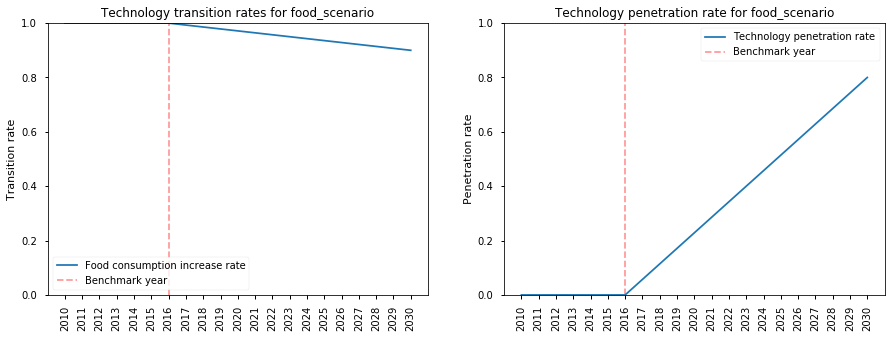

In [3]:
plot_transition_rate(
    {"Technology penetration rate": pr,
     "Food consumption increase rate": Food},
     "food_scenario")

In [4]:
sampling_rules = {
    "i_Urbanity == '1'": 30,
    "Income >= 15000": 60,
}

In [5]:
file_name = "data/survey_Sorsogon_food.csv"
scenario_name="food_scenario"
reduction = {'Food':Food}

In [6]:
reduce_consumption(
    file_name, pr, sampling_rules, reduction, scenario_name=scenario_name)

00.00%      Food       reduction; efficiency 00.00%; penetration 00.00; year 2010
00.00%      Food       reduction; efficiency 00.00%; penetration 00.00; year 2011
00.00%      Food       reduction; efficiency 00.00%; penetration 00.00; year 2012
-0.00%      Food       reduction; efficiency 00.00%; penetration 00.00; year 2013
00.00%      Food       reduction; efficiency 00.00%; penetration 00.00; year 2014
00.00%      Food       reduction; efficiency 00.00%; penetration 00.00; year 2015
00.00%      Food       reduction; efficiency 00.00%; penetration 00.00; year 2016
00.04%      Food       reduction; efficiency 00.71%; penetration 00.06; year 2017
00.16%      Food       reduction; efficiency 01.43%; penetration 00.11; year 2018
00.37%      Food       reduction; efficiency 02.14%; penetration 00.17; year 2019
00.66%      Food       reduction; efficiency 02.86%; penetration 00.23; year 2020
01.01%      Food       reduction; efficiency 03.57%; penetration 00.29; year 2021
01.47%      Food

## 6. Visualize transition scenarios

In [1]:
from smum.microsim.util_plot import plot_data_projection
from smum.microsim.run import transition_rate

In [2]:
iterations = 1000
typ = 'reweighted'
scenario_name="food_scenario"
reweighted_survey = 'data/survey_Sorsogon_food'
pr = transition_rate(0, 0.8, start=2016)
var = ['Food']

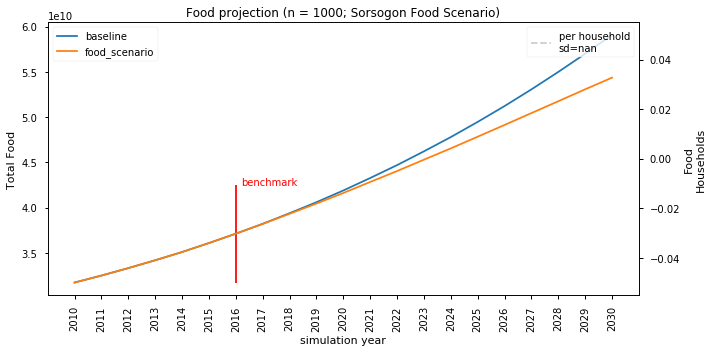

In [3]:
data, cap = plot_data_projection(
    reweighted_survey, var, "{}; Sorsogon Food Scenario".format(iterations),
    benchmark_year=2016, pr=pr, scenario_name=scenario_name, aspect_ratio=2
)

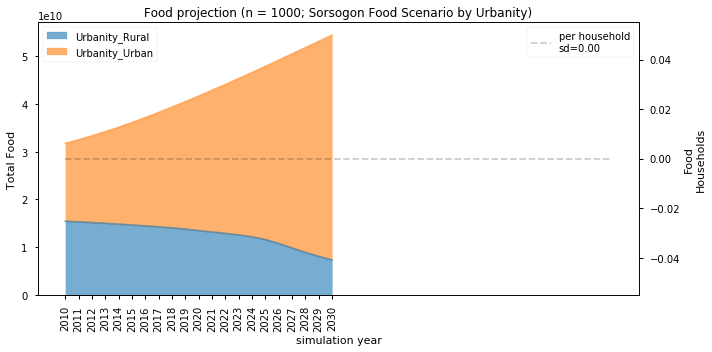

In [4]:
_, _ = plot_data_projection(
    reweighted_survey, var, "{}; Sorsogon Food Scenario by Urbanity".format(iterations),
    pr = pr, scenario_name = scenario_name,
    groupby = 'i_Urbanity', aspect_ratio=2
)

## 7. Income increase scenario

In [1]:
from smum.microsim.run import run_calibrated_model
from smum.microsim.table import TableModel

/home/esteban/workspace/python/urbanmetabolism_repo/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
census_file = 'data/benchmarks_year_bias.csv'

In [3]:
tm = TableModel(census_file = census_file)

In [4]:
tm.from_excel("data/tableModel_Income2.xlsx", "Income")
formula_income = "i_Intercept +\
    c_i_Sex        * i_Sex + \
    c_i_Urbanity   * i_Urbanity + \
    c_i_Size       * i_Size + \
    c_i_Age        * i_Age + \
    c_i_Education  * i_Education"
tm.add_formula(formula_income, 'Income')

In [5]:
tm.from_excel("data/tableModel_Food.xlsx", "Food")
formula_income = "f_Intercept +\
    c_f_Sex        * i_Sex + \
    c_f_Urbanity   * i_Urbanity + \
    c_f_Size       * i_Size + \
    c_f_Age        * i_Age + \
    c_f_Education  * i_Education +\
    c_f_Income     * Income"
tm.add_formula(formula_income, 'Food')

In [6]:
table_model = tm.make_model()

In [7]:
labels = ['age_0_18', 'age_19_25', 'age_26_35',
          'age_36_45', 'age_46_55', 'age_56_65',
          'age_66_75', 'age_76_85', 'age_86_100']
cut = [0, 19, 26, 36, 46, 56, 66, 76, 86, 101]
to_cat = {'i_Age':[cut, labels]}
drop_col_survey = ['f_Income', 'f_Education', '']

In [8]:
fw = run_calibrated_model(
    table_model,
    project = 'resampled',
    census_file = census_file,
    year = 2016,
    name = "Sorsogon_food_income_increase",
    drop_col_survey = drop_col_survey,
    to_cat = to_cat,
)

loop: 1/3; calibrating: Income; sufix = loop_1


100%|██████████| 1510/1510 [00:08<00:00, 183.72it/s]


loop: 2/3; calibrating: Food; sufix = loop_2


100%|██████████| 1510/1510 [00:09<00:00, 155.93it/s]


loop: 3/3; final loop, for variables: Income, Food; sufix = loop_3


100%|██████████| 1510/1510 [00:08<00:00, 173.93it/s]


Calibration Error:
	1.5844E-06  Income
	-1.3165E+01  Food
Projecting sample survey for 21 steps via resample
resampling for year 2010


100%|██████████| 1510/1510 [00:08<00:00, 183.76it/s]


resampling for year 2011


100%|██████████| 1510/1510 [00:09<00:00, 163.96it/s]


resampling for year 2012


100%|██████████| 1510/1510 [00:09<00:00, 161.57it/s]


resampling for year 2013


100%|██████████| 1510/1510 [00:08<00:00, 178.59it/s]


resampling for year 2014


100%|██████████| 1510/1510 [00:09<00:00, 166.74it/s]


resampling for year 2015


100%|██████████| 1510/1510 [00:09<00:00, 163.45it/s]


resampling for year 2016


100%|██████████| 1510/1510 [00:08<00:00, 182.06it/s]


resampling for year 2017


100%|██████████| 1510/1510 [00:09<00:00, 162.01it/s]


resampling for year 2018


100%|██████████| 1510/1510 [00:08<00:00, 175.55it/s]


resampling for year 2019


100%|██████████| 1510/1510 [00:08<00:00, 179.11it/s]


resampling for year 2020


100%|██████████| 1510/1510 [00:08<00:00, 169.58it/s]


resampling for year 2021


100%|██████████| 1510/1510 [00:09<00:00, 158.50it/s]


resampling for year 2022


100%|██████████| 1510/1510 [00:08<00:00, 168.27it/s]


resampling for year 2023


100%|██████████| 1510/1510 [00:09<00:00, 162.67it/s]


resampling for year 2024


100%|██████████| 1510/1510 [00:09<00:00, 163.15it/s]


resampling for year 2025


100%|██████████| 1510/1510 [00:08<00:00, 178.77it/s]


resampling for year 2026


100%|██████████| 1510/1510 [00:10<00:00, 149.22it/s]


resampling for year 2027


100%|██████████| 1510/1510 [00:10<00:00, 149.04it/s]


resampling for year 2028


100%|██████████| 1510/1510 [00:08<00:00, 176.32it/s]


resampling for year 2029


100%|██████████| 1510/1510 [00:08<00:00, 176.79it/s]


resampling for year 2030


100%|██████████| 1510/1510 [00:09<00:00, 166.46it/s]


In [9]:
from smum.microsim.util_plot import plot_error

In [10]:
from smum.microsim.run import transition_rate
from smum.microsim.util_plot import plot_transition_rate
from smum.microsim.run import reduce_consumption

In [11]:
Food  = transition_rate(0, 0.1, start=2016)
pr    = transition_rate(0, 0.8, start=2016)

In [12]:
sampling_rules = {
    "i_Urbanity == '1'": 30,
    "Income >= 15000": 60,
}

In [13]:
file_name = "data/survey_Sorsogon_food_income_increase_{}.csv"
scenario_name="food_scenario_income_increase"
reduction = {'Food':Food}

In [14]:
reduce_consumption(
    file_name, pr, sampling_rules, reduction,
    method = 'resample',
    scenario_name=scenario_name)

00.00%       all       reduction; efficiency rate 00.00%;              year 2010 and penetration rate 00.00
00.00%       all       reduction; efficiency rate 00.00%;              year 2011 and penetration rate 00.00
00.00%       all       reduction; efficiency rate 00.00%;              year 2012 and penetration rate 00.00
00.00%       all       reduction; efficiency rate 00.00%;              year 2013 and penetration rate 00.00
00.00%       all       reduction; efficiency rate 00.00%;              year 2014 and penetration rate 00.00
00.00%       all       reduction; efficiency rate 00.00%;              year 2015 and penetration rate 00.00
00.00%       all       reduction; efficiency rate 00.00%;              year 2016 and penetration rate 00.00
00.04%      Food       reduction; efficiency rate 00.71%; penetration 00.06; year 2017
00.16%      Food       reduction; efficiency rate 01.43%; penetration 00.11; year 2018
00.37%      Food       reduction; efficiency rate 02.14%; penetration 

In [9]:
from smum.microsim.util_plot import plot_data_projection
from smum.microsim.run import transition_rate
import pandas as pd

In [10]:
iterations = 1000
typ = 'reweighted'
scenario_name="food_scenario_income_increase"
reweighted_survey = 'data/survey_Sorsogon_food_income_increase'
pr = transition_rate(0, 0.8, start=2016)
var = ['Food']

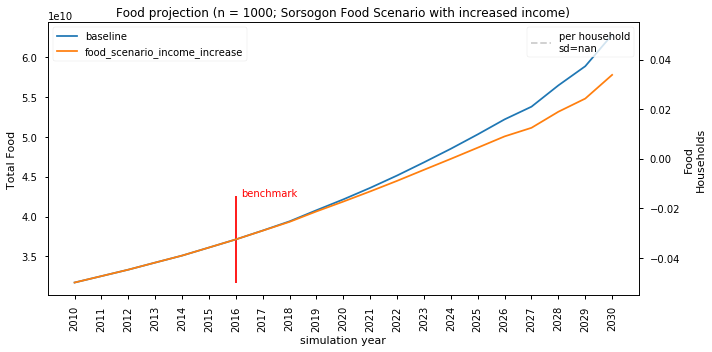

In [11]:
data2, cap2 = plot_data_projection(
    reweighted_survey, var, "{}; Sorsogon Food Scenario with increased income".format(iterations),
    benchmark_year=2016, pr=pr, scenario_name=scenario_name, aspect_ratio=2,
)

In [12]:
ticks = [int(y) for y in range(2010, 2031)]
data.index = ticks
data2.index = ticks
Data = pd.DataFrame({'food_scenario':data, 'food_scenario_income_increase':data2})

In [13]:
import matplotlib.pyplot as plt

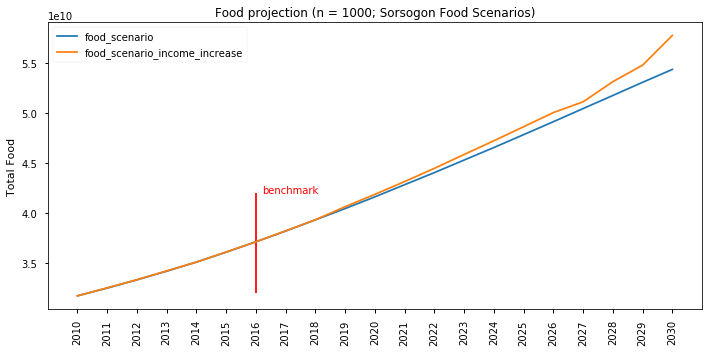

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 5))
Data.plot(ax=ax)
ax.vlines(2016, 3.2e10, 4.2e10, color='r')
ax.text(2016+0.2, 4.2e10, 'benchmark',color='r')
ax.set_title("Food projection (n = 1000; Sorsogon Food Scenarios)")
ax.set_ylabel("Total Food")
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=90);
plt.tight_layout()
plt.savefig('FIGURES/projected_Food_Scenarios.png', dpi=300)